In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import time
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [ ]:
class Run:
    def __init__(self, file, nevents):
        self.file = Path(file) 
        self.nevents = nevents
        self.meta_data = None
        self.output_data = None
    
    def print_nevents_in_file(self):
        f = up.open(self.file)
        print(f"There are {f['output'].num_entries} events in {self.file}")

    def load_meta_data(self):
        f = up.open(self.file)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time() 
        self.meta_data = f['meta'].arrays([
            'pmtType',
            'pmtId',
            'pmtChannel',
            'pmtIsOnline',
            'pmtCableOffset',
        ], entry_start=0, entry_stop=self.nevents, library='ak') 
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load meta data for {self.nevents} events")

    def load_event_data(self):
        f=up.open(self.file)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp',
            'timeSinceLastTrigger_us',
            'digitPMTID',
            'digitTime',
            'digitCharge',
            'digitPeak',
            'digitNegativePeak',
            'x_quadfitter',
            'y_quadfitter',
            'z_quadfitter',
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load output data for {self.nevents} events")



In [155]:
sra_cosmics_file = '/nfs/disk1/eos/eos-processed-data-nubar/run1246/data-1246.root'
central_515_laserball_file = '/nfs/disk1/eos/eos-processed-data-nubar/run3064/data-3064.root'
water_cosmics_file = '/nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root'
sanity_file = '/nfs/disk1/users/bharris/eos/new_sim/processed/eos_run1246_000.ntuple.root'


run = Run(water_cosmics_file,nevents=10000)
run.print_nevents_in_file()
run.load_meta_data()
run.load_event_data()



There are 4996811 events in /nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Took 0.02 seconds to load meta data for 10000 events
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcn

In [156]:
print(run.output_data['digitCharge'][0])


[4.22, 5.01, 12.7, 1.59, 3.92, 14.2, ..., 5.09, 2.23, 1.95, 2.17, 1.91, 1.47]


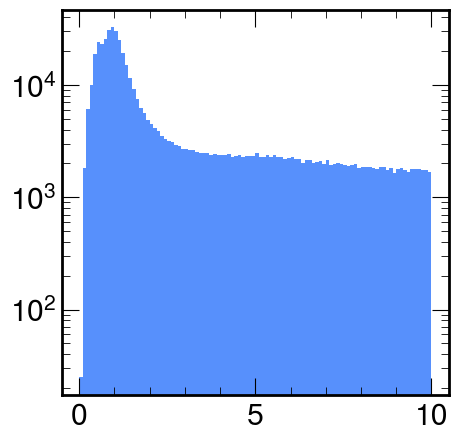

In [157]:
digit_peak = run.output_data['digitPeak']
digit_neg_peak = run.output_data['digitNegativePeak']
ratio = digit_peak / digit_neg_peak
flat_ratio = ak.flatten(ratio)

plt.figure(figsize=(5,5))
plt.hist(flat_ratio,bins=100,range=(0,10))
plt.semilogy();

In [158]:
charge = run.output_data['digitCharge']
charge_cut = charge > 0

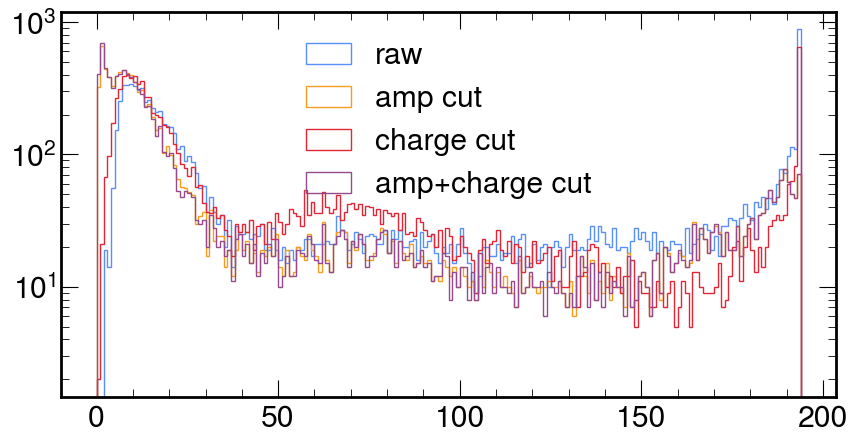

In [159]:
amp_cut = ratio > 2 # should play around with this

nhits = ak.num(run.output_data['digitCharge'])
amp_nhits = ak.num(run.output_data['digitCharge'][amp_cut])
charge_nhits = ak.num(run.output_data['digitCharge'][charge_cut])
amp_charge_nhits = ak.num(run.output_data['digitCharge'][charge_cut & amp_cut])

max_nhit = np.max([np.max(nhits),np.max(nhits)])
plt.figure(figsize=(10,5))
plt.hist(nhits,bins=max_nhit,range=(0,max_nhit),histtype='step',label='raw');
plt.hist(amp_nhits,bins=max_nhit,range=(0,max_nhit),histtype='step',label='amp cut');
plt.hist(charge_nhits,bins=max_nhit,range=(0,max_nhit),histtype='step',label='charge cut');
plt.hist(amp_charge_nhits,bins=max_nhit,range=(0,max_nhit),histtype='step',label='amp+charge cut');
plt.semilogy()
plt.legend(loc='upper center')

In [160]:
pmt_ids = run.meta_data['pmtId'][0]
pmt_chs = run.meta_data['pmtChannel'][0]

id2ch = dict(zip(pmt_ids, pmt_chs))
ch2id = dict(zip(pmt_chs, pmt_ids))
id2board = dict(zip(ch2id.values(), [ch//16 for ch in ch2id.keys()]))


digit_ids = run.output_data['digitPMTID']
digit_time = run.output_data['digitTime']
flat_digit_time = ak.flatten(digit_time)

In [161]:
# from collections import defaultdict
# from tqdm import tqdm

# board_times = defaultdict(list)
# channel_times = defaultdict(list)

# for event_ids, event_times in tqdm(zip(digit_ids, digit_time)):
#     for pmtid, time in zip(event_ids, event_times):
#         board = id2board.get(pmtid, None)
#         if board is not None:
#             board_times[board].append(time)
#         channel = id2ch.get(pmtid, None)
#         if channel is not None:
#             channel_times[channel].append(time)

# board_times_np = {board: np.array(times) for board, times in board_times.items()}
# channel_times_np = {channel: np.array(times) for channel, times in channel_times.items()}

# fig,ax = plt.subplots(1,2,figsize=(15,5))

# for board, times in sorted(board_times_np.items()):
#     ax[0].hist(times, bins=100, range=(-200,200), histtype='step', label=f'Board {board}')

# ax[0].set_xlabel("Hit Time (ns)")
# ax[0].set_ylabel("Counts")
# ax[0].set_title("Hit Time Distribution by Board")
# ax[0].legend(ncol=3,fontsize=8)
# ax[0].set_xlim(-200,200)

# for channel, times in sorted(channel_times_np.items()):
#     ax[1].hist(times, bins=100, range=(-200,200),histtype='step', label=f'Board {channel}')

# ax[1].set_xlabel("Hit Time (ns)")
# ax[1].set_ylabel("Counts")
# ax[1].set_title("Hit Time Distribution by Channel")



In [162]:

# # Compute cable delays per channel
# cable_delays = {}
# aligned_channel_times = {}
# peak_centers = [] 
# for ch, times in channel_times.items():
#     counts, bins = np.histogram(times, bins=200, range=(-200, 200))
#     peak_bin = np.argmax(counts)
#     peak_center = 0.5 * (bins[peak_bin] + bins[peak_bin+1])
#     peak_centers.append(peak_center)
#     cable_delays[ch] = peak_center
#     aligned_channel_times[ch] = times - peak_center

# # Write cable delays to file 
# # Convert keys to built-in int
# cleaned_delays = {int(k): float(v) for k, v in cable_delays.items()}
import json
# with open('cable_delays.json', 'w') as f:
#     json.dump(cleaned_delays, f, indent=2)


# Load cable delays from file
with open('cable_delays.json', 'r') as f:
    cable_delays = json.load(f)
    cable_delays = {int(k): float(v) for k, v in cable_delays.items()}


print(cable_delays)

{112: 111.0, 225: -17.0, 113: 35.0, 115: 107.0, 240: -17.0, 241: -17.0, 45: -15.0, 54: -13.0, 65: -15.0, 75: -19.0, 77: -15.0, 136: -17.0, 204: -17.0, 151: -17.0, 224: -15.0, 226: -17.0, 227: -15.0, 228: -15.0, 229: -17.0, 230: -17.0, 231: -15.0, 232: -15.0, 233: -15.0, 116: 113.0, 234: -15.0, 235: -15.0, 118: 111.0, 242: -15.0, 243: -15.0, 244: -15.0, 119: 111.0, 245: -17.0, 246: -13.0, 120: 115.0, 121: 111.0, 247: -15.0, 249: -15.0, 250: -15.0, 123: 109.0, 251: -15.0, 258: -13.0, 259: 123.0, 261: -15.0, 262: -11.0, 265: -15.0, 267: -15.0, 0: -17.0, 1: -17.0, 2: -17.0, 3: -13.0, 4: -15.0, 5: -17.0, 6: -17.0, 9: -17.0, 10: -15.0, 11: -15.0, 12: -17.0, 13: -17.0, 14: -15.0, 184: -15.0, 16: -15.0, 17: -15.0, 18: -19.0, 19: -13.0, 21: -17.0, 22: -17.0, 24: -17.0, 25: -17.0, 26: -19.0, 27: -17.0, 28: -15.0, 29: -17.0, 30: -15.0, 185: -13.0, 32: -15.0, 33: -17.0, 34: -15.0, 35: -19.0, 37: -17.0, 38: -15.0, 41: -17.0, 42: -17.0, 43: -17.0, 46: -15.0, 186: -17.0, 48: -17.0, 49: -17.0, 50: -15

In [163]:


# # Apply corrections again to full data
# corrected_channel_times = defaultdict(list)
# corrected_board_times = defaultdict(list)

# for ids, times in zip(run.output_data['digitPMTID'], run.output_data['digitTime']):
#     for pmt_id, time in zip(ids, times):
#         board = id2board.get(pmt_id, None)
#         ch = id2ch.get(pmt_id, None)
#         delay = cable_delays.get(ch, None)
#         # Only apply cable delay correction to dichroicon board (and weird channel 259)
#         # Also shift everything to be centered around 0 
#         if board==7 or ch==259:
#             if ch is not None:
#                 corrected_channel_times[ch].append(time - delay) 
#             if board is not None:
#                 corrected_board_times[board].append(time - delay)
#         else:
#             if ch is not None:
#                 corrected_channel_times[ch].append(time - np.median(cable_delays))
#             if board is not None:
#                 corrected_board_times[board].append(time - np.median(cable_delays))


# corrected_board_times_np = {board: np.array(times) for board, times in corrected_board_times.items()}
# corrected_channel_times_np = {channel: np.array(times) for channel, times in corrected_channel_times.items()}

# def plot_flattened_time_distributions(channel_hit_times, corrected_channel_hit_times):
#     # Flatten all times
#     all_raw = np.concatenate(list(channel_hit_times.values()))
#     all_corrected = np.concatenate(list(corrected_channel_hit_times.values()))
    
#     plt.figure(figsize=(12, 6))
#     plt.hist(all_raw, bins=400, range=(-200, 200), histtype='step', label='Before Delay Correction', color='tab:blue')
#     plt.hist(all_corrected, bins=400, range=(-200, 200), histtype='step', label='After Delay Correction', color='tab:orange')
#     plt.axvline(0, color='gray', linestyle='--', label='Expected Peak')
#     plt.xlabel('Hit Time (ns)')
#     plt.ylabel('Total Counts')
#     plt.title('Flattened Hit Time Distribution Across All Channels')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# fig,ax = plt.subplots(1,2,figsize=(15,5))

# for board, times in sorted(corrected_board_times_np.items()):
#     ax[0].hist(times, bins=100, range=(-200,200), histtype='step', label=f'Board {board}')

# ax[0].set_xlabel("Hit Time (ns)")
# ax[0].set_ylabel("Counts")
# ax[0].set_title("Hit Time Distribution by Board")
# ax[0].legend(ncol=3,fontsize=8)
# ax[0].set_xlim(-200,200)

# for channel, times in sorted(corrected_channel_times_np.items()):
#     ax[1].hist(times, bins=100, range=(-200,200),histtype='step', label=f'Channel {channel}')

# ax[1].set_xlabel("Hit Time (ns)")
# ax[1].set_ylabel("Counts")
# ax[1].set_title("Hit Time Distribution by Channel")


In [164]:
# plot_flattened_time_distributions(channel_times_np, corrected_channel_times_np)

In [165]:
# print(f"There were {len(corrected_channel_times_np)}/{len(id2ch)} working channels for this run, or {len(corrected_channel_times_np)/len(id2ch)*100:.2f}%")
# print(sorted(corrected_channel_times.keys()))

In [166]:
# Now do the same thing but in original format to keep track of event information 


# # Step 1: Get the median shift for all channels
# median_peak_center = np.median(list(cable_delays.values()))
# print("median peak",median_peak_center)

# # Step 2: Prepare digit data
# ids_all = run.output_data['digitPMTID']
# times_all = run.output_data['digitTime']

# # Step 3: Lookup channels and boards for each PMT ID
# channels_all = ak.Array([[id2ch.get(pmt_id, None) for pmt_id in event] for event in ids_all])
# boards_all = ak.Array([[id2board.get(pmt_id, None) for pmt_id in event] for event in ids_all])

# # Step 4: Get delay for each channel (or None if not found)
# delays_all = ak.Array([[cable_delays.get(ch, median_peak_center) if ch is not None else median_peak_center 
#                         for ch in event] for event in channels_all])

# # Step 5: Build correction mask for conditional logic
# is_special_case = ak.Array([[ (board == 7 or ch == 259) for board, ch in zip(bevt, chevt)] 
#                             for bevt, chevt in zip(boards_all, channels_all)])

# # Step 6: Compute corrected times
# corrected_times = ak.where(
#     is_special_case,
#     times_all - delays_all,                    # Special case: use channel delay
#     times_all - median_peak_center             # General case: use median
# )

# # Step 7: Build the mask
# cut = [-20,20]
# time_cut = (corrected_times > cut[0]) & (corrected_times < cut[1])

# # Example: masked digitTime
# masked_times = ak.mask(times_all, time_cut)

# # Example: filtered (drops None entries)
# filtered_times = times_all[time_cut]

# plt.figure(figsize=(12, 6))
# plt.hist(ak.flatten(times_all), bins=400, range=(-200, 200), histtype='step', label='Before Delay Correction', color='tab:blue')
# plt.hist(ak.flatten(corrected_times), bins=400, range=(-200, 200), histtype='step', label='After Delay Correction', color='tab:orange')
# plt.axvline(0, color='gray', linestyle='--', label='Expected Peak')
# plt.axvspan(cut[0],cut[1],color='grey',alpha=0.2)
# plt.xlabel('Hit Time (ns)')
# plt.ylabel('Total Counts')
# plt.title('Flattened Hit Time Distribution Across All Channels')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [167]:
# import numpy as np
# import awkward as ak
# import matplotlib.pyplot as plt

# # Step 1: Get the median shift for all channels
# median_peak_center = np.median(list(cable_delays.values()))
# print("median peak", median_peak_center)

# # Step 2: Prepare digit data
# ids_all = run.output_data['digitPMTID']
# times_all = run.output_data['digitTime']

# # Step 3: Vectorized lookup for channels and boards
# vec_id2ch = np.vectorize(lambda pid: id2ch.get(pid, None))
# vec_id2board = np.vectorize(lambda pid: id2board.get(pid, None))

# channels_all = ak.Array(vec_id2ch(ids_all))
# boards_all = ak.Array(vec_id2board(ids_all))

# # Step 4: Vectorized delay lookup
# vec_delay = np.vectorize(lambda ch: cable_delays.get(ch, median_peak_center) if ch is not None else median_peak_center)
# delays_all = ak.Array(vec_delay(channels_all))

# # Step 5: Build special case mask using Awkward zip + logic
# zipped = ak.zip({
#     "board": boards_all,
#     "channel": channels_all,
#     "time": times_all,
#     "delay": delays_all
# })

# is_special_case = (zipped.board == 7) | (zipped.channel == 259)

# # Step 6: Compute corrected times
# corrected_times = ak.where(
#     is_special_case,
#     zipped.time - zipped.delay,
#     zipped.time - median_peak_center
# )

# # Step 7: Build time cut mask
# cut = [-20, 20]
# time_cut = (corrected_times > cut[0]) & (corrected_times < cut[1])

# # Example: masked digitTime (optional if you're only using filtered)
# masked_times = ak.mask(times_all, time_cut)

# # Example: filtered (drops None entries)
# filtered_times = times_all[time_cut]

# # Plot
# plt.figure(figsize=(12, 6))
# plt.hist(ak.flatten(times_all), bins=400, range=(-200, 200), histtype='step',
#          label='Before Delay Correction', color='tab:blue')
# plt.hist(ak.flatten(corrected_times), bins=400, range=(-200, 200), histtype='step',
#          label='After Delay Correction', color='tab:orange')
# plt.axvline(0, color='gray', linestyle='--', label='Expected Peak')
# plt.axvspan(cut[0], cut[1], color='grey', alpha=0.2)
# plt.xlabel('Hit Time (ns)')
# plt.ylabel('Total Counts')
# plt.title('Flattened Hit Time Distribution Across All Channels')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [168]:
# import numpy as np
# import awkward as ak
# import matplotlib.pyplot as plt

# # Step 1: Get the median shift for all channels
# median_peak_center = np.median(list(cable_delays.values()))
# print("median peak", median_peak_center)

# # Step 2: Prepare digit data
# ids_all = run.output_data['digitPMTID']
# times_all = run.output_data['digitTime']

# # Step 3: Map channel and board using list comprehension + Awkward structure
# channels_all = ak.Array([[id2ch.get(pid, None) for pid in event] for event in ids_all])
# boards_all = ak.Array([[id2board.get(pid, None) for pid in event] for event in ids_all])

# # Step 4: Lookup delay for each channel (fallback to median)
# delays_all = ak.Array([[cable_delays.get(ch, median_peak_center) if ch is not None else median_peak_center
#                         for ch in event] for event in channels_all])

# # Step 5: Build special case mask
# zipped = ak.zip({
#     "board": boards_all,
#     "channel": channels_all,
#     "time": times_all,
#     "delay": delays_all
# })

# is_special_case = (zipped.board == 7) | (zipped.channel == 259)

# # Step 6: Compute corrected times
# corrected_times = ak.where(
#     is_special_case,
#     zipped.time - zipped.delay,
#     zipped.time - median_peak_center
# )

# # Step 7: Time cut
# cut = [-20, 20]
# time_cut = (corrected_times > cut[0]) & (corrected_times < cut[1])

# # Optional: filtered output
# masked_times = ak.mask(times_all, time_cut)
# filtered_times = times_all[time_cut]

# # Plot
# plt.figure(figsize=(12, 6))
# plt.hist(ak.flatten(times_all), bins=400, range=(-200, 200), histtype='step',
#          label='Raw', color='tab:blue')
# plt.hist(ak.flatten(corrected_times), bins=400, range=(-200, 200), histtype='step',
#          label='After Dichroicon Cable Delay + Global shift', color='tab:orange')
# plt.axvline(0, color='gray', linestyle='--', label='Expected Peak')
# plt.axvspan(cut[0], cut[1], color='grey', alpha=0.2)
# plt.xlabel('Hit Time (ns)')
# plt.ylabel('Total Counts')
# plt.title('Digit Time Distribution Across All Channels')
# plt.legend()
# plt.tight_layout()
# plt.show()


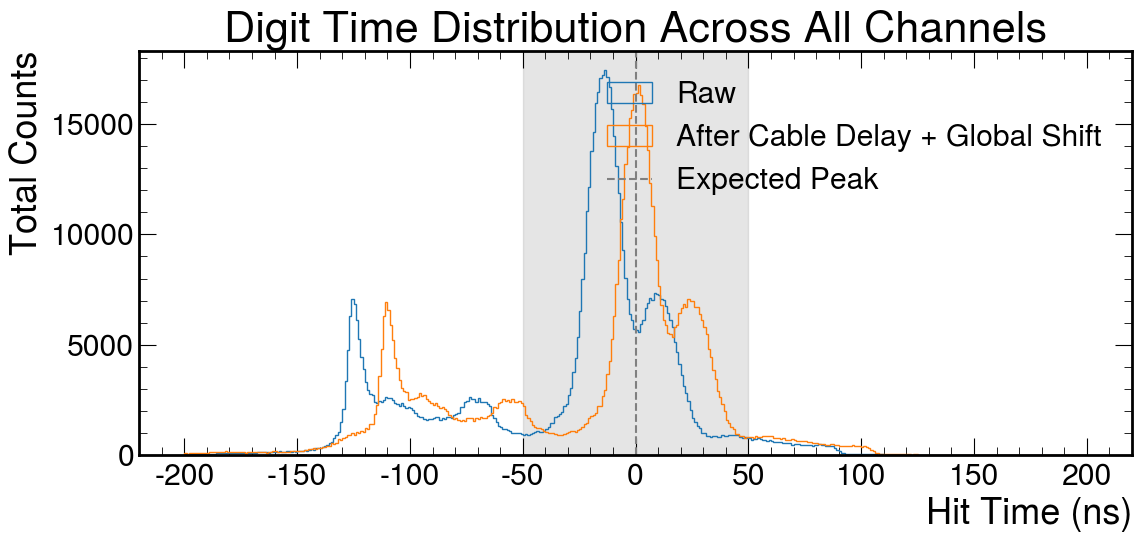

In [169]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Step 1: Get the median shift
median_peak_center = np.median(list(cable_delays.values()))

# Step 2: Digit data
ids_all = run.output_data['digitPMTID']
times_all = run.output_data['digitTime']

# Step 3: Convert mapping dicts to arrays (for vectorized lookup)
# Use high enough max ID to safely index
max_pid = ak.max(ids_all)
pid_array = np.arange(max_pid + 1)

# Build lookup arrays using numpy, then broadcast using awkward
id2ch_array = np.full(max_pid + 1, -1)
id2board_array = np.full(max_pid + 1, -1)

for pid, ch in id2ch.items():
    id2ch_array[pid] = ch
for pid, b in id2board.items():
    id2board_array[pid] = b

# Apply mapping in vectorized way
ids_all_flat = ak.flatten(ids_all)
channels_flat = id2ch_array[ids_all_flat]
boards_flat = id2board_array[ids_all_flat]

# Restore jagged structure
channels_all = ak.unflatten(channels_flat, ak.num(ids_all))
boards_all = ak.unflatten(boards_flat, ak.num(ids_all))

# Step 4: cable_delays vectorized
max_ch = np.max(channels_flat[channels_flat >= 0])
cable_delay_array = np.full(max_ch + 1, median_peak_center)
for ch, delay in cable_delays.items():
    cable_delay_array[ch] = delay

delays_flat = cable_delay_array[channels_flat.clip(min=0)]
delays_all = ak.unflatten(delays_flat, ak.num(ids_all))

# Step 5: Special case mask
zipped = ak.zip({
    "board": boards_all,
    "channel": channels_all,
    "time": times_all,
    "delay": delays_all
})

is_special_case = (zipped.board == 7) | (zipped.channel == 259)

# Step 6: Corrected times
corrected_times = ak.where(
    is_special_case,
    zipped.time - zipped.delay,
    zipped.time - median_peak_center
)

# Step 7: Time cut
cut = [-50, 50]
time_cut = (corrected_times > cut[0]) & (corrected_times < cut[1])

# Optional: filtered output
filtered_times = times_all[time_cut]

# Plot
plt.figure(figsize=(12, 6))
plt.hist(ak.flatten(times_all), bins=400, range=(-200, 200), histtype='step',
         label='Raw', color='tab:blue')
plt.hist(ak.flatten(corrected_times), bins=400, range=(-200, 200), histtype='step',
         label='After Cable Delay + Global Shift', color='tab:orange')
plt.axvline(0, color='gray', linestyle='--', label='Expected Peak')
plt.axvspan(cut[0], cut[1], color='grey', alpha=0.2)
plt.xlabel('Hit Time (ns)')
plt.ylabel('Total Counts')
plt.title('Digit Time Distribution Across All Channels')
plt.legend()
plt.tight_layout()
plt.show()


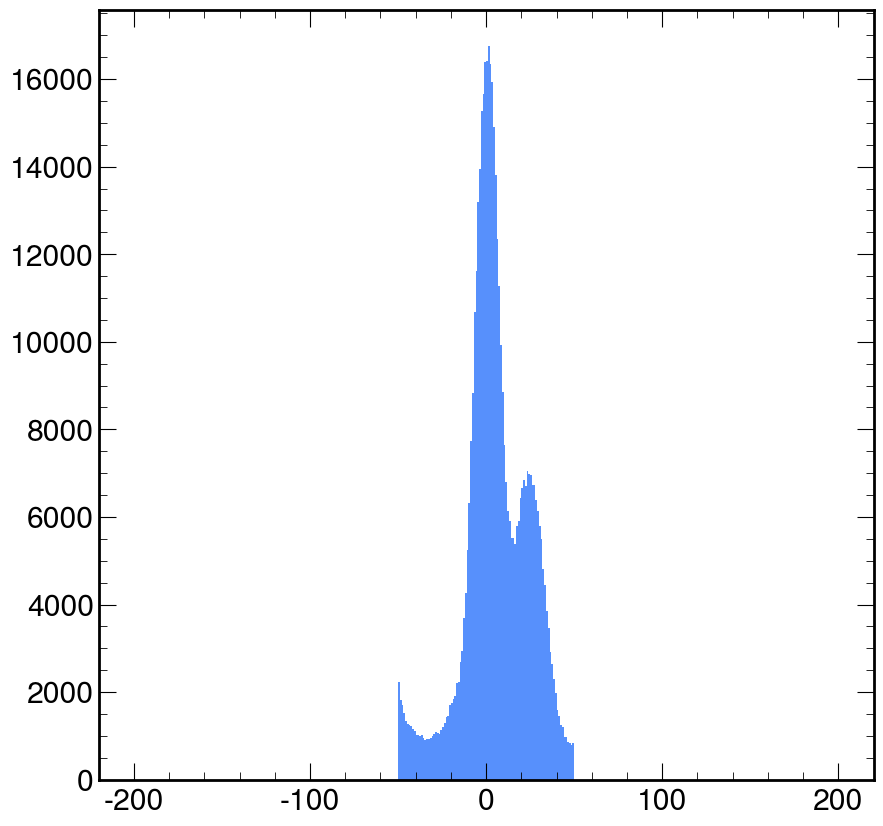

In [170]:


times = run.output_data['digitTime']
cut_times = corrected_times[time_cut]
plt.hist(ak.flatten(cut_times),bins=400,range=(-200,200));



In [171]:


# for i in range(10,15):
#     print(f"\nEvent {i}")
#     print("Original times:", times_all[i])
#     print("Corrected times:", corrected_times[i])
#     print("Mask:", time_cut[i])
#     print(len(time_cut[i][time_cut[i]==True]))
#     #print("Filtered times:", filtered_times[i])
#     # plt.hist(times_all[i],bins=400,range=(-200,200),histtype='step',label='original')
#     plt.hist(corrected_times[i],bins=50,range=(-100,100),histtype='step',label='corrected')
#     plt.axvspan(-20,20,color='grey',alpha=0.2)
#     #plt.hist(filtered_times[i],bins=400,range=(-200,200),histtype='step',label='filtered')
#     plt.legend()
#     plt.show()



[]

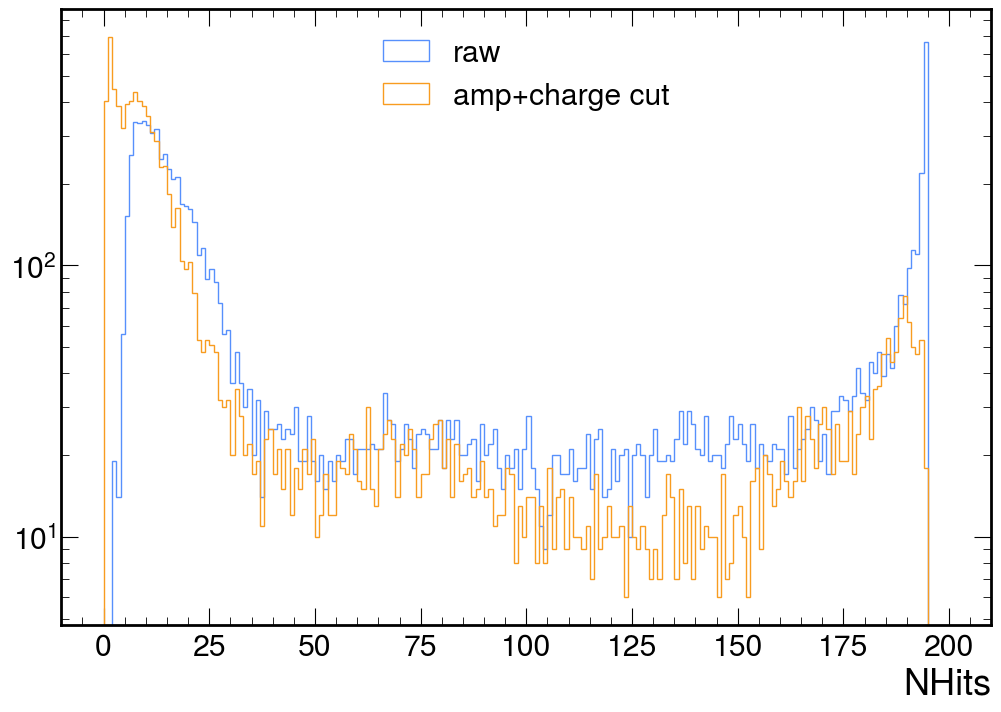

In [214]:
amp_cut = ratio > 2

raw_nhits = ak.num(run.output_data['digitCharge'])
amp_charge_cut_nhits = ak.num(run.output_data['digitCharge'][amp_cut & charge_cut])
# time_cut_nhits = ak.num(run.output_data['digitCharge'][time_cut])
# amp_time_cut_nhits = ak.num(run.output_data['digitCharge'][amp_cut & time_cut])

# max_nhit = np.max(raw_nhits)
# bins=int(max_nhit/2)
max_nhit=200
bins=200

plt.figure(figsize=(12,8))
plt.hist(raw_nhits,bins=bins,range=(0,max_nhit),histtype='step',label=f"raw")
plt.hist(amp_charge_cut_nhits,bins=bins,range=(0,max_nhit),histtype='step',label="amp+charge cut")
# plt.hist(time_cut_nhits,bins=bins,range=(0,max_nhit),histtype='step',label='time cut');
# plt.hist(amp_time_cut_nhits,bins=bins,range=(0,max_nhit),histtype='step',label='amp and time cut');
plt.legend(loc='upper center')
plt.xlabel('NHits')
plt.semilogy()

In [215]:
prompt_min_nhit = 170
delayed_min_nhit = 50

# Define prompt and delayed event masks
prompt_raw_mask = raw_nhits >= prompt_min_nhit
delayed_raw_mask = (raw_nhits >= delayed_min_nhit) & (raw_nhits < prompt_min_nhit)

prompt_amp_mask = amp_charge_cut_nhits >= prompt_min_nhit
delayed_amp_mask = (amp_charge_cut_nhits >= delayed_min_nhit) & (amp_charge_cut_nhits < prompt_min_nhit)

# prompt_time_mask = time_cut_nhits > prompt_min_nhit
# delayed_time_mask = (time_cut_nhits > delayed_min_nhit) & (time_cut_nhits <= prompt_min_nhit)

# prompt_amp_time_mask = amp_time_cut_nhits > prompt_min_nhit
# delayed_amp_time_mask = (amp_time_cut_nhits > delayed_min_nhit) & (amp_time_cut_nhits <= prompt_min_nhit)

print("Raw prompts",len(raw_nhits[prompt_raw_mask]))
print("Raw delayed",len(raw_nhits[delayed_raw_mask]))

print("Cut prompts",len(raw_nhits[prompt_amp_mask]))
print("Cut delayed",len(raw_nhits[delayed_amp_mask]))


Raw prompts 2011
Raw delayed 2502
Cut prompts 927
Cut delayed 1761


In [194]:
# Count number of prompt events for each case
print(f"(raw): {ak.sum(prompt_raw_mask)} prompt {ak.sum(delayed_raw_mask)} delayed {ak.sum(prompt_raw_mask)+ak.sum(delayed_raw_mask)} total")
print(f"(amp cut): {ak.sum(prompt_amp_mask)} prompt {ak.sum(delayed_amp_mask)} delayed {ak.sum(prompt_amp_mask)+ak.sum(delayed_amp_mask)} total")
# print(f"(time cut): {ak.sum(prompt_time_mask)} prompt {ak.sum(delayed_time_mask)} delayed {ak.sum(prompt_time_mask)+ak.sum(delayed_time_mask)} total")
# print(f"(amp + time): {ak.sum(prompt_amp_time_mask)} prompt {ak.sum(delayed_amp_time_mask)} delayed {ak.sum(prompt_amp_time_mask)+ak.sum(delayed_amp_time_mask)} total")

# # Or to apply the event mask to get, say, digitTime for prompt amp+time cut:
# prompt_amp_time_digitTimes = run.output_data['digitTime'][prompt_amp_time_mask]


(raw): 2011 prompt 2502 delayed 4513 total
(amp cut): 927 prompt 1761 delayed 2688 total


In [195]:
event_masks = {
    "prompt_raw": prompt_raw_mask,
    "delayed_raw": delayed_raw_mask,
    "prompt_amp": prompt_amp_mask,
    "delayed_amp": delayed_amp_mask,
    # "prompt_time": prompt_time_mask,
    # "delayed_time": delayed_time_mask,
    # "prompt_amp_time": prompt_amp_time_mask,
    # "delayed_amp_time": delayed_amp_time_mask,
}


In [196]:
import numpy as np
import awkward as ak

def compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_mask, delayed_mask):
   
    timestamps = np.asarray(timestamps)
    prompt_times = timestamps[prompt_mask]
    delayed_times = timestamps[delayed_mask]
    
    delta_ts = []
    i_prompt = 0

    for delayed_time in delayed_times:
        # Advance through prompt_times as long as they're in the past
        while i_prompt + 1 < len(prompt_times) and prompt_times[i_prompt + 1] < delayed_time:
            i_prompt += 1
        
        if prompt_times[i_prompt] < delayed_time:
            delta_ts.append(delayed_time - prompt_times[i_prompt])
            
        else:
            # No prior prompt found (e.g., delayed event came before all prompts)
            delta_ts.append(np.nan)
    
    return np.array(delta_ts)


timestamps = run.output_data['timestamp']

dt_raw = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_raw_mask, delayed_raw_mask)
dt_amp_charge = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_amp_mask, delayed_amp_mask)
# dt_time= compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_time_mask, delayed_time_mask)
# dt_amp_time = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_amp_time_mask, delayed_amp_time_mask)

#print(np.diff(np.unique(np.sort(dt_amp))))


Text(1, 0, 'Delayed Trigger Time Since Last Prompt Trigger ($\\mu$s)')

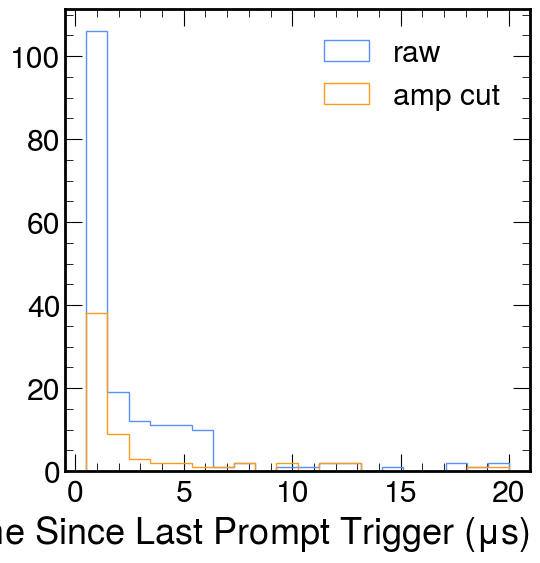

In [197]:
bins=20
trange=(0.5,20)
plt.figure(figsize=(6,6))
plt.hist(dt_raw/1e3,bins=bins,range=trange,histtype='step',label='raw')
plt.hist(dt_amp_charge/1e3,bins=bins,range=trange,histtype='step',label='amp cut')
#plt.hist(dt_time/1e3,bins=bins,range=trange,histtype='step',label='time cut')
#plt.hist(dt_amp_time/1e3,bins=bins,range=trange,histtype='step',label='amp + time cut')
plt.legend(loc='upper right')
plt.xlabel('Delayed Trigger Time Since Last Prompt Trigger ($\mu$s)')
#plt.semilogy()


In [198]:



import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def decay_model(t, A, tau, B):
    return (A / tau) * np.exp(-t / tau) + B

def fit_decay(data, bins=20, range=(0.5, 20), tau_guess=2):
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    sigma = np.sqrt(counts)
    sigma[sigma == 0] = 1.0  # Avoid divide by zero

    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma,
                           absolute_sigma=True, p0=p0, maxfev=100000)
    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))
    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    return {
        "bin_centers": bin_centers,
        "counts": counts,
        "sigma": sigma,
        "popt": popt,
        "perr": [A_err, tau_err, B_err],
        "chi2": chi2,
        "chi2_red": chi2_red,
    }


In [205]:
def compare_decay_fits(datasets, labels, colors, bins=10, range=(0.4,20.4), tau_guess=2):
    results = []
    plt.figure(figsize=(8, 8))

    for data, label, color in zip(datasets, labels, colors):
        result = fit_decay(data, bins=bins, range=range, tau_guess=tau_guess)
        results.append(result)

        bin_centers = result['bin_centers']
        counts = result['counts']
        sigma = result['sigma']
        A, tau, B = result['popt']
        tau_err = result['perr'][1]

        plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color=color, label=f"{label} (τ = {tau:.2f} ± {tau_err:.2f})")

        t_fine = np.linspace(*range, 1000)
        plt.plot(t_fine, decay_model(t_fine, *result['popt']), '-', color=color)

    plt.xlabel("ΔT (µs)", fontsize=18)
    plt.ylabel(f"Counts / {(range[1] - range[0]) / bins:.2f} µs", fontsize=18)
    plt.title("Comparison of Decay Time Fits", fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.ylim(0,500)
    # plt.xlim(range)
    #plt.semilogy()
    plt.show()

    # Print summary table
    print("\nFit Summary:")
    print(f"{'Label':<15} {'Tau (µs)':<15} {'Tau Err':<10} {'Chi²/dof':<10}")
    for label, res in zip(labels, results):
        tau = res['popt'][1]
        tau_err = res['perr'][1]
        chi2_red = res['chi2_red']
        print(f"{label:<15} {tau:<15.3f} {tau_err:<10.3f} {chi2_red:<10.3f}")

    return results


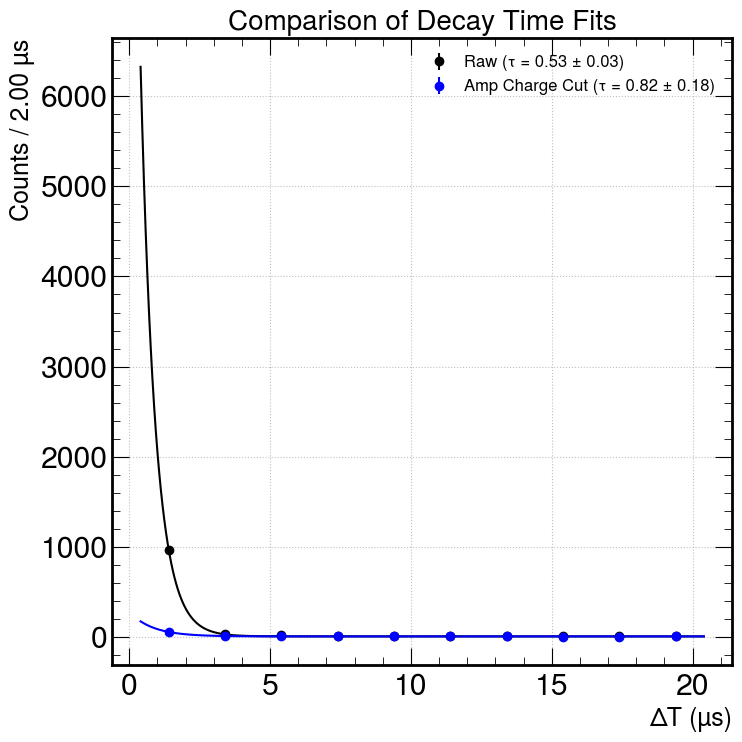


Fit Summary:
Label           Tau (µs)        Tau Err    Chi²/dof  
Raw             0.531           0.031      3.072     
Amp Charge Cut  0.822           0.181      0.914     


In [206]:
# datasets = [dt_raw/1e3, dt_amp/1e3, dt_time/1e3, dt_amp_time/1e3]
# labels = ['Raw', 'Amp Cut', 'Time Cut', 'Amp+Time Cut']
# colors = ['black', 'blue', 'green', 'red']

# results = compare_decay_fits(datasets, labels, colors)

datasets = [dt_raw/1e3, dt_amp_charge/1e3]
labels = ['Raw', 'Amp Charge Cut']
colors = ['black', 'blue']

results = compare_decay_fits(datasets, labels, colors)



21


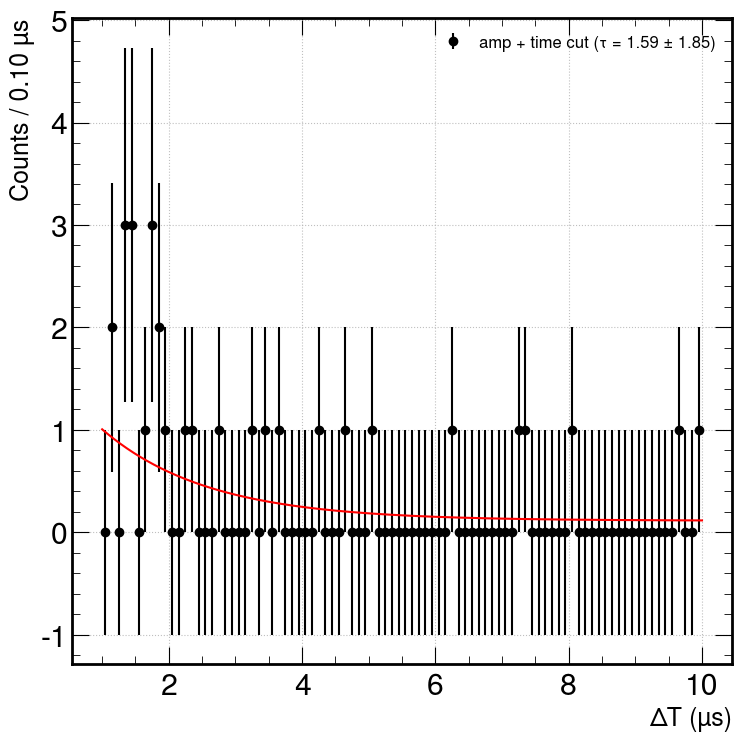

In [202]:
plt.figure(figsize=(8, 8))

bins=90
range=(1,10)

result = fit_decay(dt_amp_charge/1e3, bins=bins, range=range, tau_guess=2)
bin_centers = result['bin_centers']
counts = result['counts']
sigma = result['sigma']
A, tau, B = result['popt']
tau_err = result['perr'][1]

test = (dt_amp_charge> 1000) & (dt_amp_charge<= 4000)
print(len(dt_amp_charge[test]))


plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label=f"amp + time cut (τ = {tau:.2f} ± {tau_err:.2f})")
t_fine = np.linspace(*range, 1000)

plt.plot(t_fine, decay_model(t_fine, *result['popt']), '-', color='red')
plt.xlabel("ΔT (µs)", fontsize=18)
plt.ylabel(f"Counts / {(range[1] - range[0]) / bins:.2f} µs", fontsize=18)
#plt.title("Comparison of Decay Time Fits", fontsize=20)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.ylim(0,500)
# plt.xlim(range)
#plt.semilogy()
plt.show()






Start: 10000
Cut prompts 927
Cut delayed 1761
1761
52


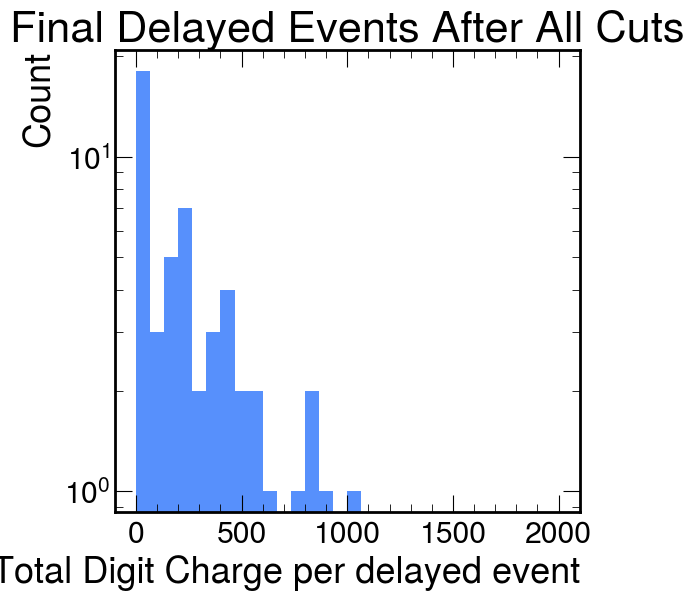

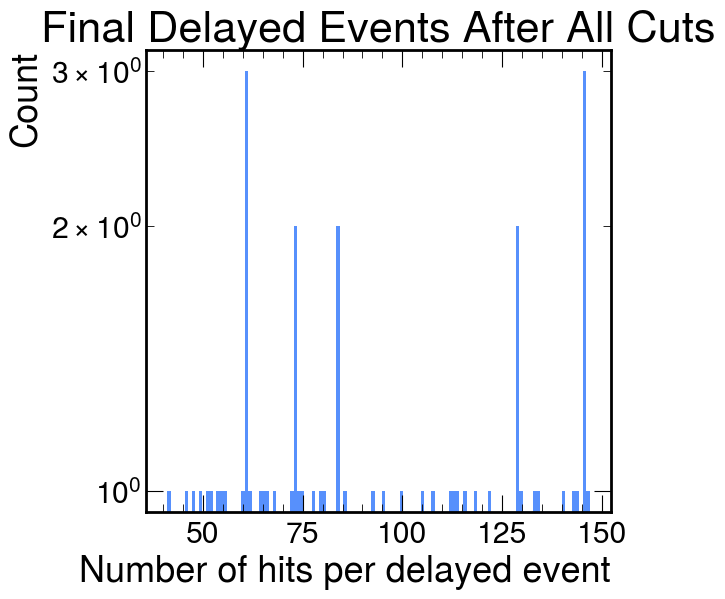

In [226]:
import awkward as ak
import matplotlib.pyplot as plt

# 1. Compute [event][hit] amplitude ratio cut
digit_charge = run.output_data['digitCharge']
digit_peak = run.output_data['digitPeak']
digit_neg_peak = run.output_data['digitNegativePeak']
ratio = digit_peak / digit_neg_peak
amp_cut = ratio > 2  # [event][hit]
charge_cut = digit_charge > 0

print(f"Start: {len(digit_charge)}")

# # 2. Compute [event][hit] time cut
# cut = [-10, 10]
# #corrected_times = ...  # make sure this is defined before
# time_cut = (corrected_times > cut[0]) & (corrected_times < cut[1])  # [event][hit]

# 3. Combine hit-level cuts
combined_hit_mask = amp_cut & charge_cut #& time_cut  # [event][hit]

# 4. Apply hit-level cuts
digit_charge_cleaned = ak.mask(run.output_data['digitCharge'], combined_hit_mask)
digit_time_cleaned   = ak.mask(run.output_data['digitTime'], combined_hit_mask)

# 5a. Count remaining hits to build per-event nhit
hit_cleaned_nhit = ak.count(digit_charge_cleaned,axis=1)  # [event]

prompt_min_nhit = 170
delayed_min_nhit = 50

# Define prompt and delayed event masks
prompt_mask = hit_cleaned_nhit >= prompt_min_nhit
delayed_mask = (hit_cleaned_nhit >= delayed_min_nhit) & (hit_cleaned_nhit < prompt_min_nhit)

print("Cut prompts",len(hit_cleaned_nhit[prompt_mask]))
print("Cut delayed",len(hit_cleaned_nhit[delayed_mask]))

# digit_charge_cleaned = run.output_data['digitCharge'][combined_hit_mask]
# digit_time_cleaned   = run.output_data['digitTime'][combined_hit_mask]

# # 5b. Count remaining hits to build per-event nhit
# hit_cleaned_nhit = ak.num(digit_charge_cleaned, axis=1)  # [event]

# prompt_min_nhit = 170
# delayed_min_nhit = 50

# # Define prompt and delayed event masks
# prompt_mask = hit_cleaned_nhit >= prompt_min_nhit
# delayed_mask = (hit_cleaned_nhit >= delayed_min_nhit) & (hit_cleaned_nhit < prompt_min_nhit)

# print("Cut prompts",len(hit_cleaned_nhit[prompt_mask]))
# print("Cut delayed",len(hit_cleaned_nhit[delayed_mask]))

#)

# 7. Time since last prompt, only for delayed
timestamps = run.output_data['timestamp']
dt_amp_charge= compute_delayed_times_relative_to_prompt_with_ts(
    timestamps, prompt_mask, delayed_mask
)  # [delayed events]


print(len(dt_amp_charge))


# 8. Apply delay time cut (dt < 3 µs) to delayed events
time_mask = (0 < dt_amp_charge/1e3) & (dt_amp_charge/1e3 <= 3)   # [delayed events only]

# 9. Select only delayed events that passed the time cut
# delayed_amp_time_mask is [all events] — we now filter that with time_mask
final_event_mask = ak.Array(delayed_amp_time_mask)  # shape: [events]
# Get indices of delayed events
delayed_indices = ak.where(delayed_amp_time_mask)[0]  # np.array of indices
# Apply time cut
valid_delayed_indices = delayed_indices[time_mask]  # np.array of surviving delayed event indices

# Now build final event-level mask
final_event_mask = np.zeros(len(delayed_amp_time_mask), dtype=bool)
final_event_mask[valid_delayed_indices] = True  # shape: [event]

# 10. Final cleaned arrays (hits within selected delayed events)
digit_charge_final = digit_charge_cleaned[final_event_mask]
digit_time_final   = digit_time_cleaned[final_event_mask]

print(len(digit_charge_final))

# 11. Plot number of valid hits per selected delayed event
plt.figure(figsize=(6,6))
plt.hist(ak.sum(digit_charge_final,axis=1),bins=30,range=(0,2000))
plt.xlabel("Total Digit Charge per delayed event")
plt.ylabel("Count")
plt.title("Final Delayed Events After All Cuts")
plt.yscale('log')
plt.show()

# 11. Plot number of valid hits per selected delayed event
plt.figure(figsize=(6,6))
plt.hist(ak.num(digit_charge_final,axis=1),bins=(prompt_min_nhit-delayed_min_nhit))
plt.xlabel("Number of hits per delayed event")
plt.ylabel("Count")
plt.title("Final Delayed Events After All Cuts")
plt.yscale('log')
plt.show()

In [28]:


# Event types by nhit 

# Time since last prompt event 

# Ringing

# Muon lifetime fit

# Channel delays 

# Hit time cut

# Position cut

# Normalization

# PMT plots
